<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="https://raw.githubusercontent.com/DataForScience/Networks/master/data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0" width=150px> </div>
    <div style="float: left; margin-left: 10px;"> 
        <h1>Node Centrality</h1>
        <h1>Degree, Closeness, and Betweenness Centrality</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
            @bgoncalves, @data4sci</p></div>
</div>

In [1]:
from collections import Counter
from pprint import pprint

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt 

import tqdm as tq
from tqdm import tqdm

import random
import networkx as nx

import watermark

%load_ext watermark
%matplotlib inline

We start by print out the versions of the libraries we're using for future reference

In [2]:
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

Compiler    : Clang 10.0.0 
OS          : Darwin
Release     : 20.3.0
Machine     : x86_64
Processor   : i386
CPU cores   : 16
Architecture: 64bit

Git hash: 01b3d562eeb6ccd4b41c6a0652c20a85da5248ae

tqdm      : 4.50.2
networkx  : 2.5
pandas    : 1.2.2
numpy     : 1.20.1
matplotlib: 3.3.2
watermark : 2.1.0
json      : 2.0.9



Load default figure style

In [3]:
plt.style.use('./d4sci.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Barbell ER Graph

Build a barbell graph with 2 ER graphs on each end

In [4]:
np.random.seed(42)
random.seed(42)
G = nx.erdos_renyi_graph(50, 0.1)
ER = nx.erdos_renyi_graph(50, 0.1)

ER = nx.relabel_nodes(ER, dict(map(lambda x:(x, x+51), ER.nodes)))
G.add_edges_from(ER.edges)

# Add the middle node and its two edges
G.add_edges_from([(49, 50), (50, 51)])

Compute a layout

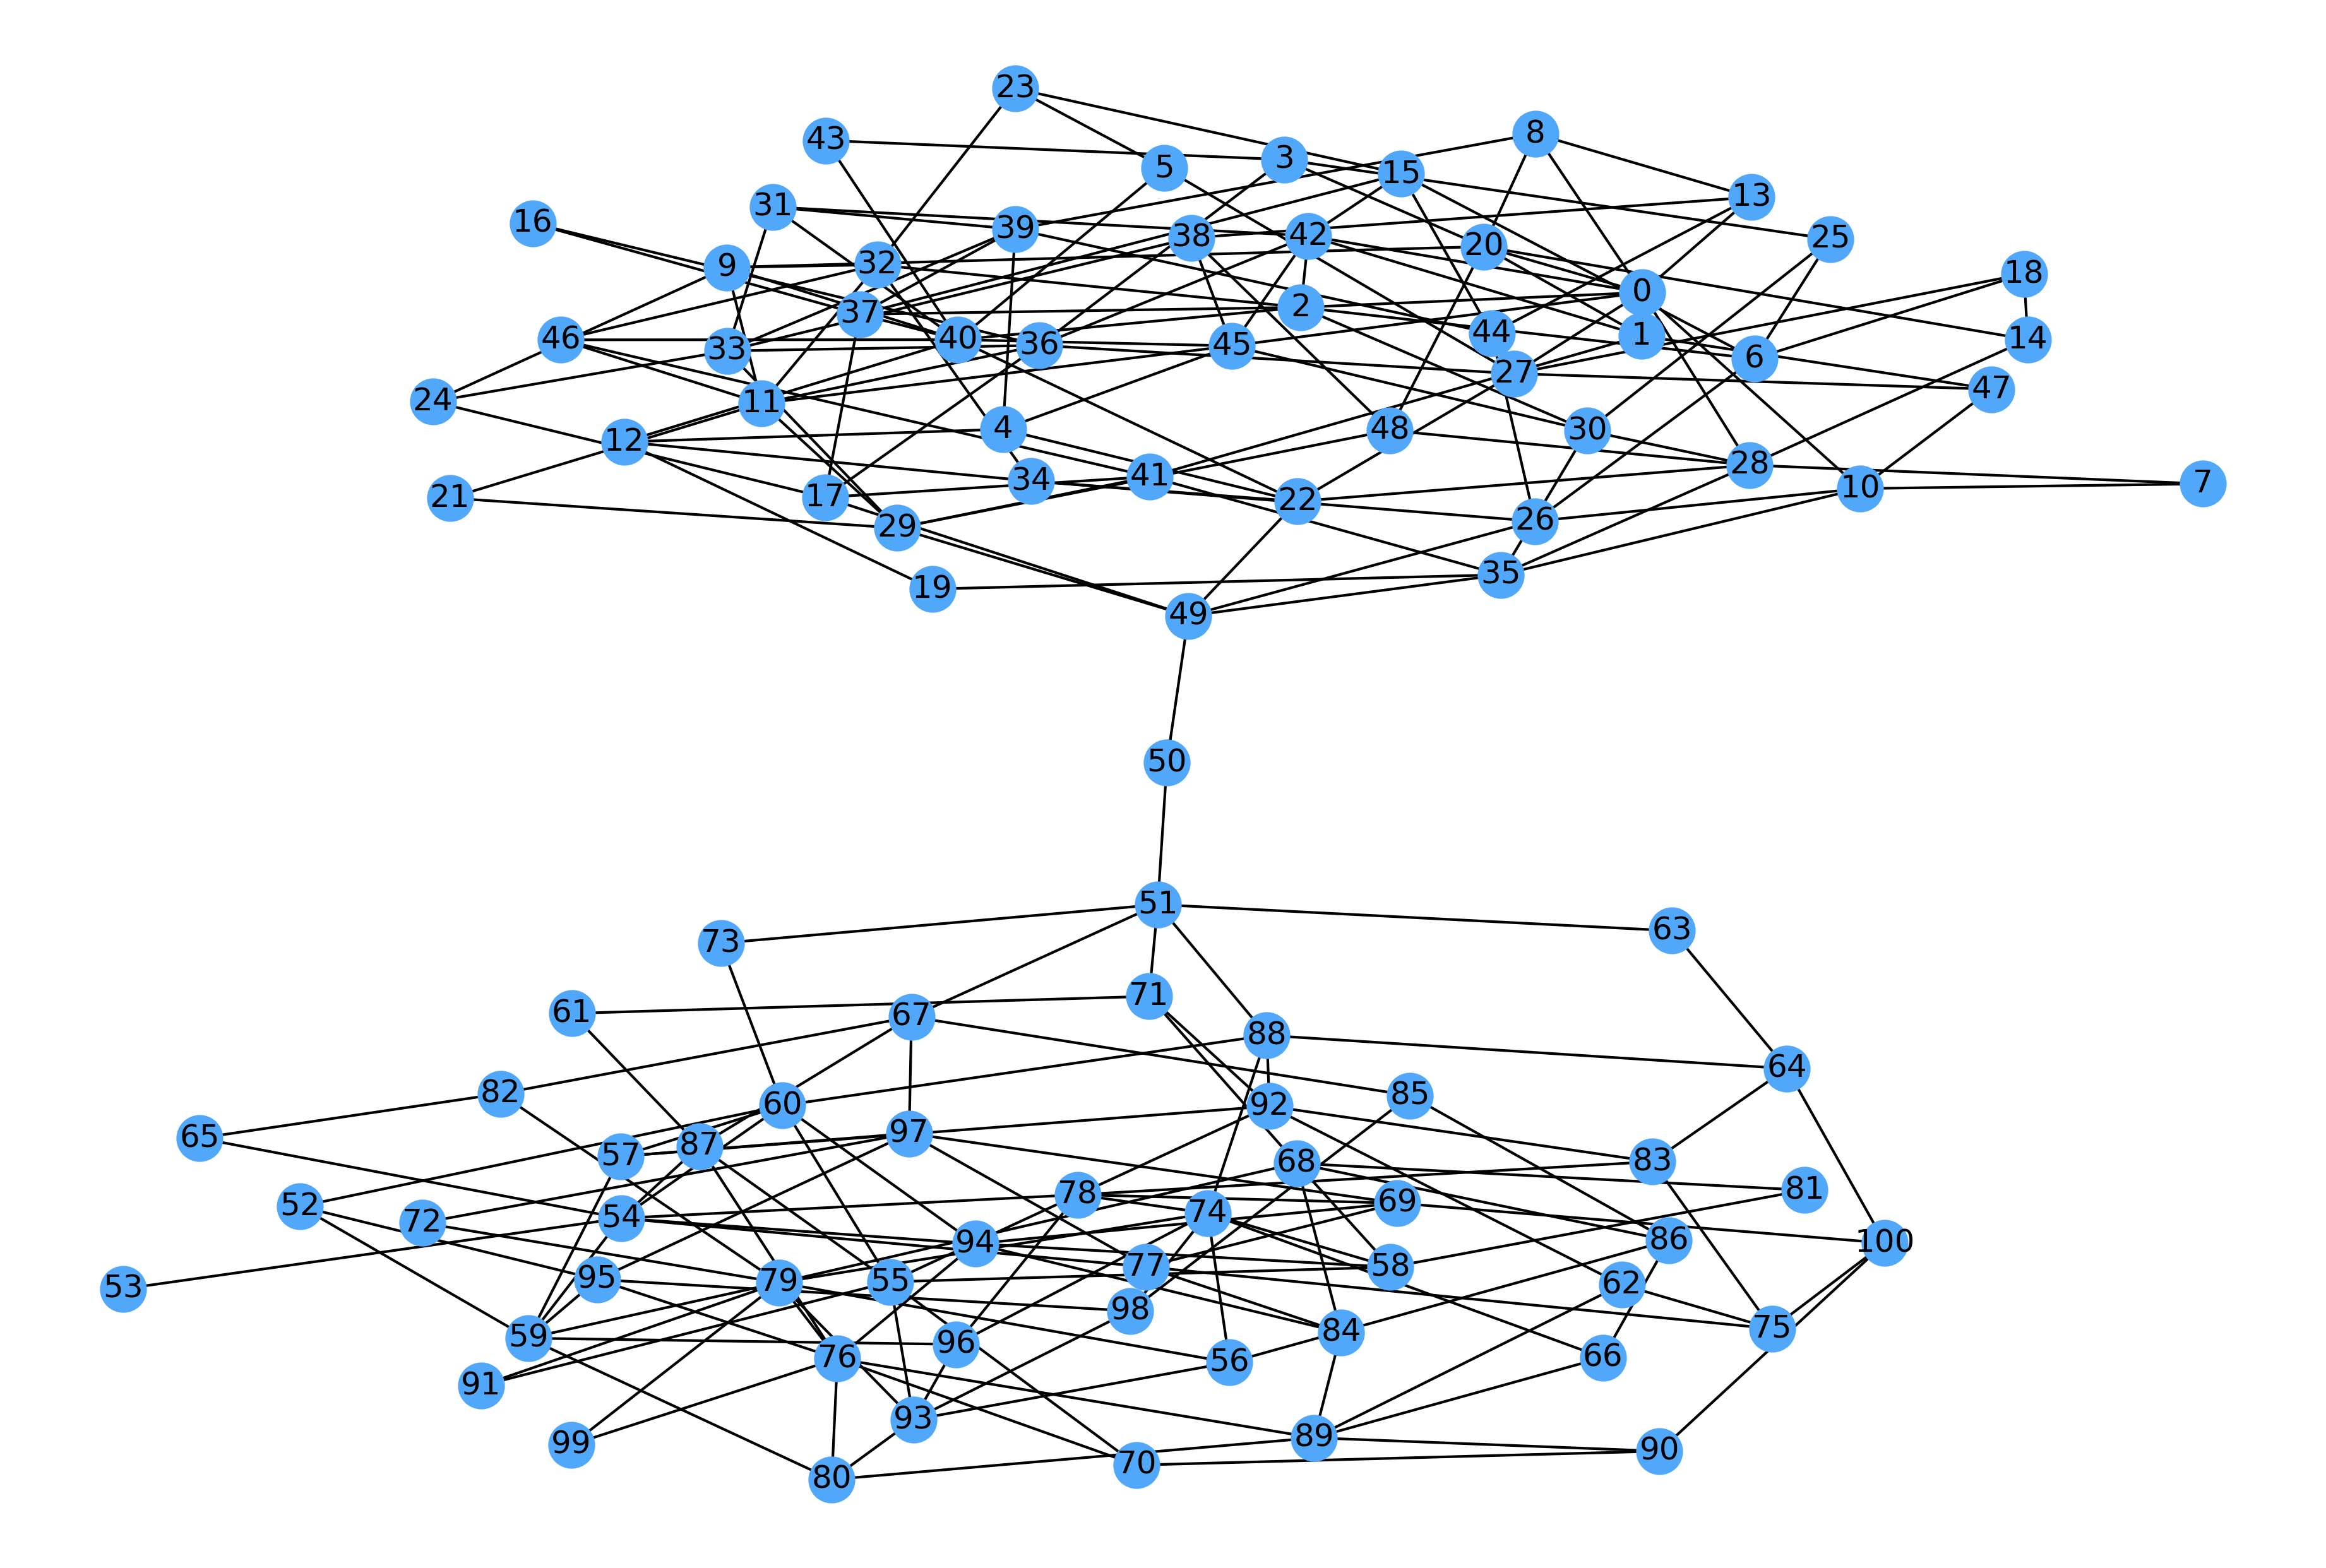

In [5]:
np.random.seed(42)
random.seed(42)

pos=nx.layout.kamada_kawai_layout(G)
nx.draw_networkx(G, pos, node_color=colors[0])
plt.gca().axis('off');

# Degree centrality

We compute the degree of each node

In [6]:
degrees = dict(nx.degree(G))

And the degree distribution

In [7]:
Nk = np.array(sorted(Counter(degrees.values()).items(), key=lambda x: x[0]))

Text(0, 0.5, 'N(k)')

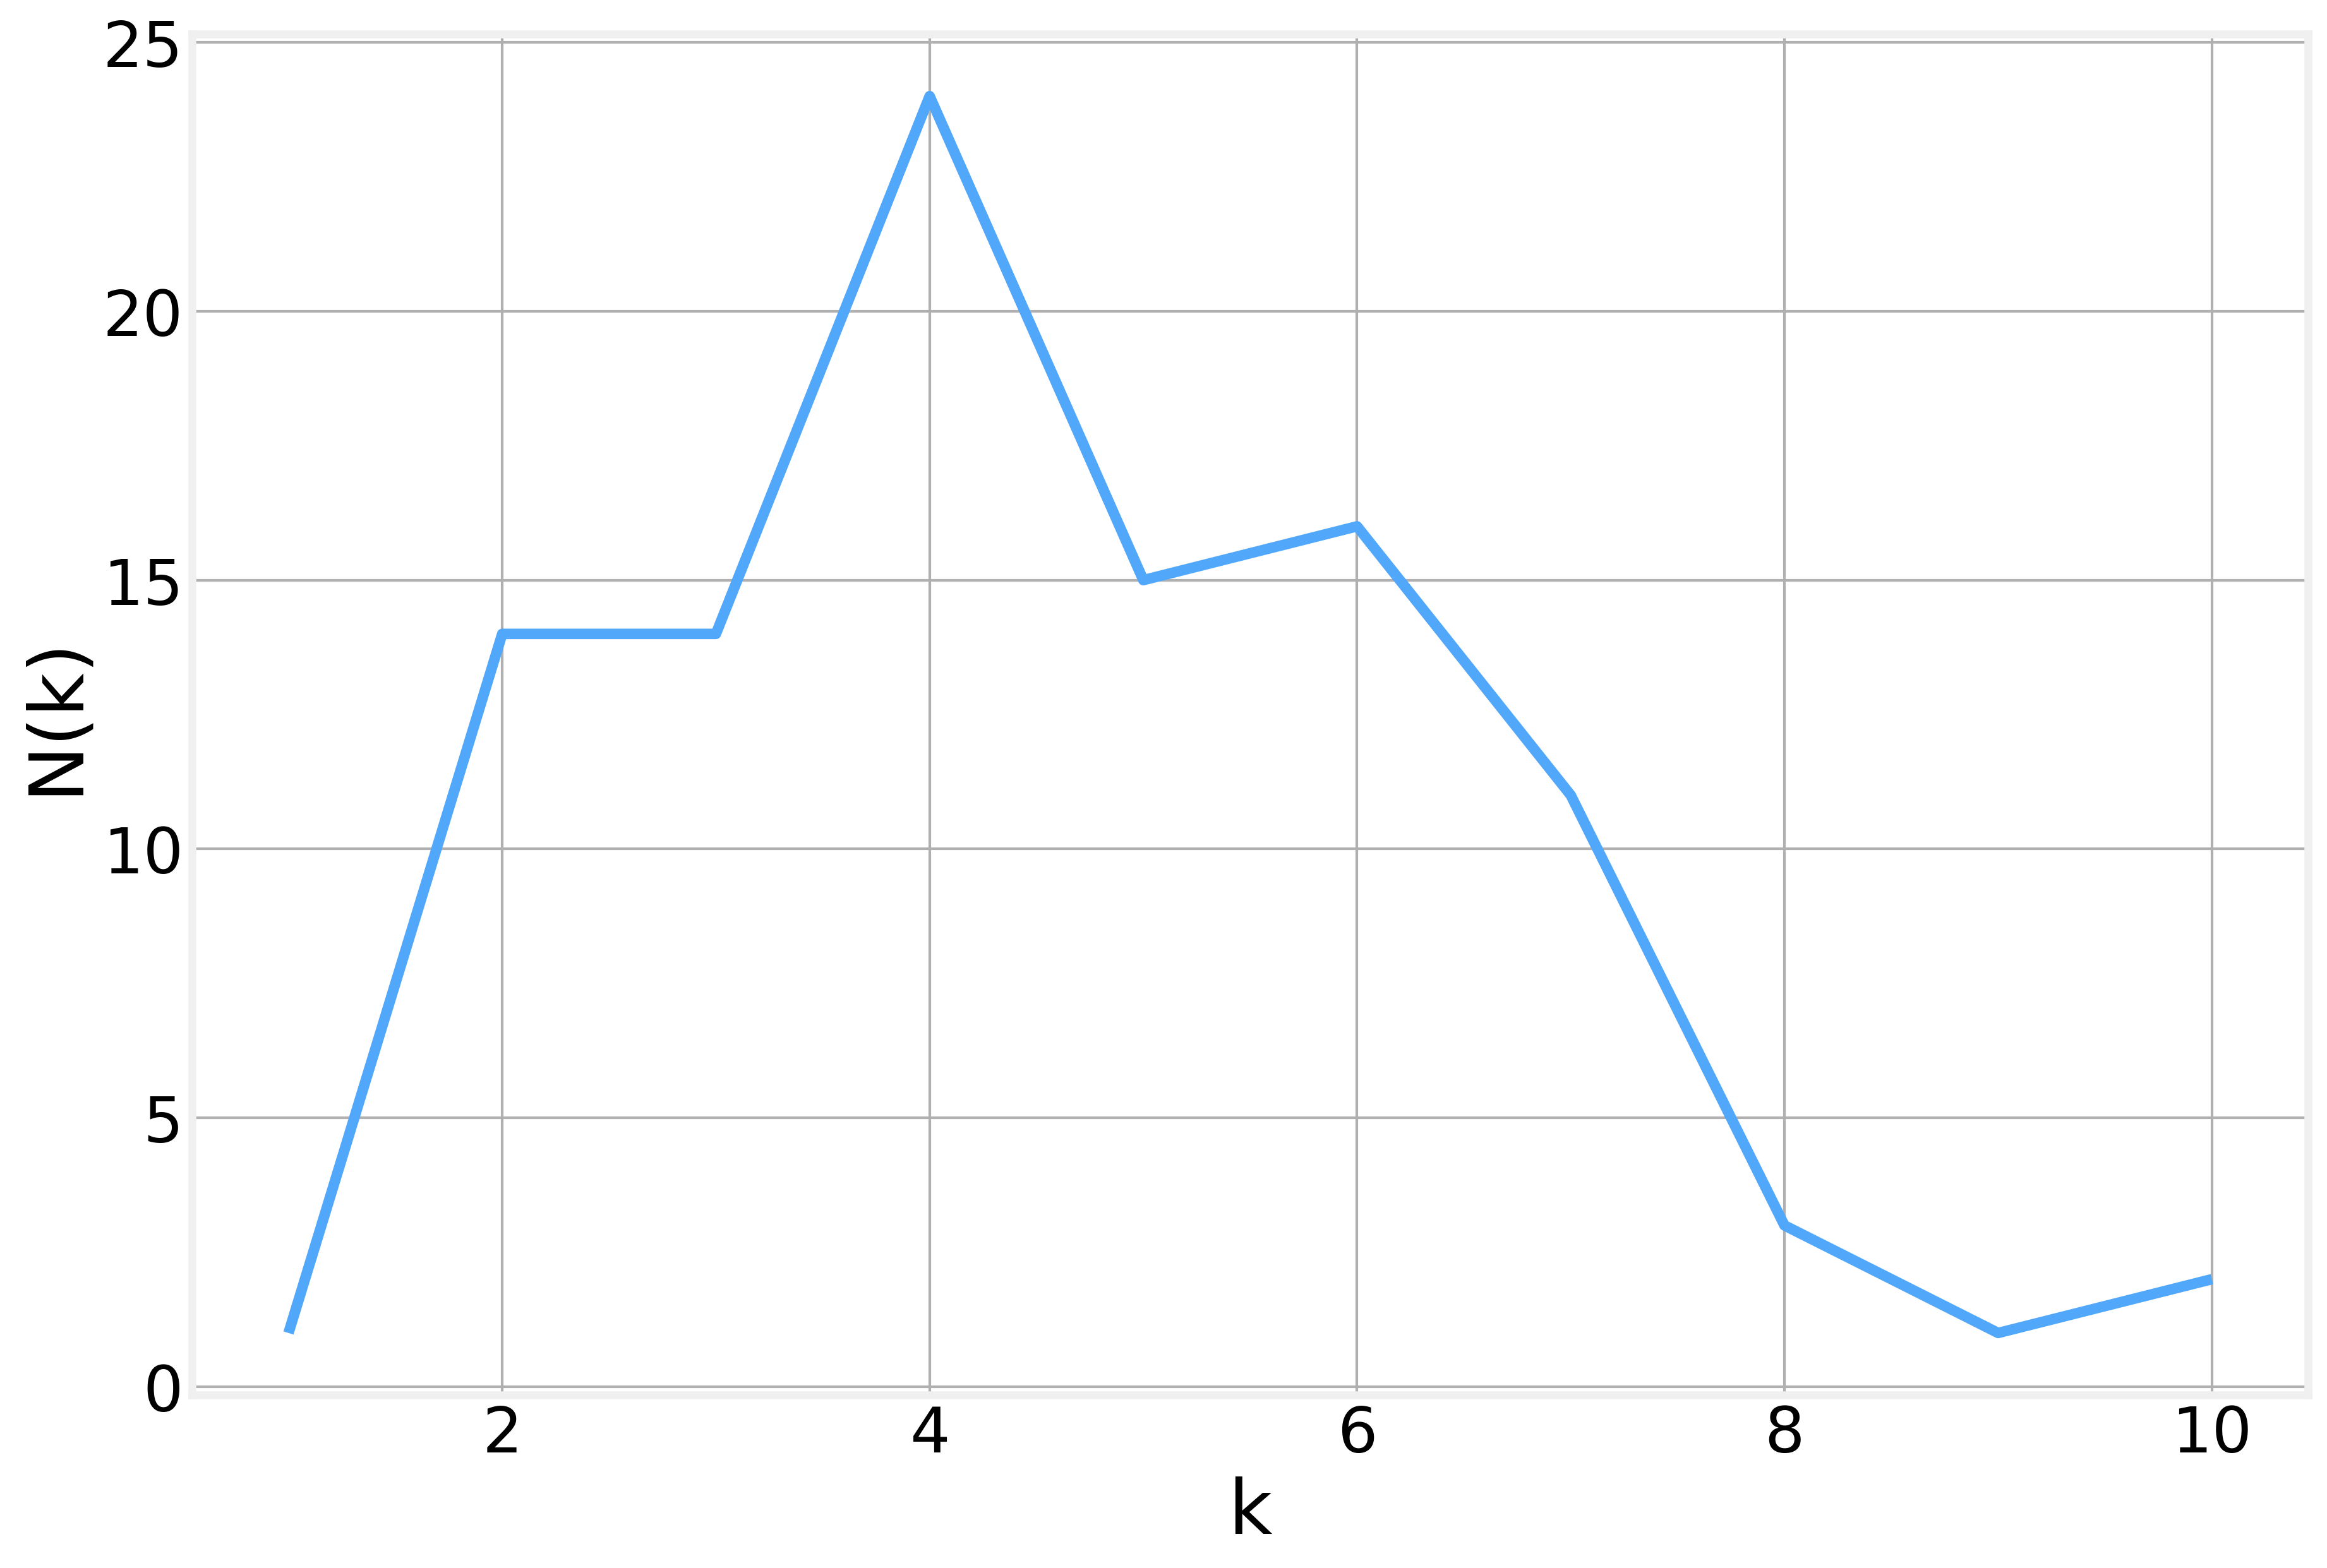

In [8]:
fig, ax = plt.subplots(1)
ax.plot(Nk.T[0], Nk.T[1].astype('int'))
ax.set_xlabel('k')
ax.set_ylabel('N(k)')

And while it makes sense that nodes with higher degree are more important, they are not the most central

In [9]:
cmap = plt.cm.RdYlGn_r

deg = pd.DataFrame(nx.degree(G)).set_index(0)

deg[1] = np.log10(1+deg[1]-deg[1].min())/np.log10(deg[1].max()+1-deg[1].min())
deg[2] = deg[1].map(lambda x: cmap(x))

And are distributed throughout the graph

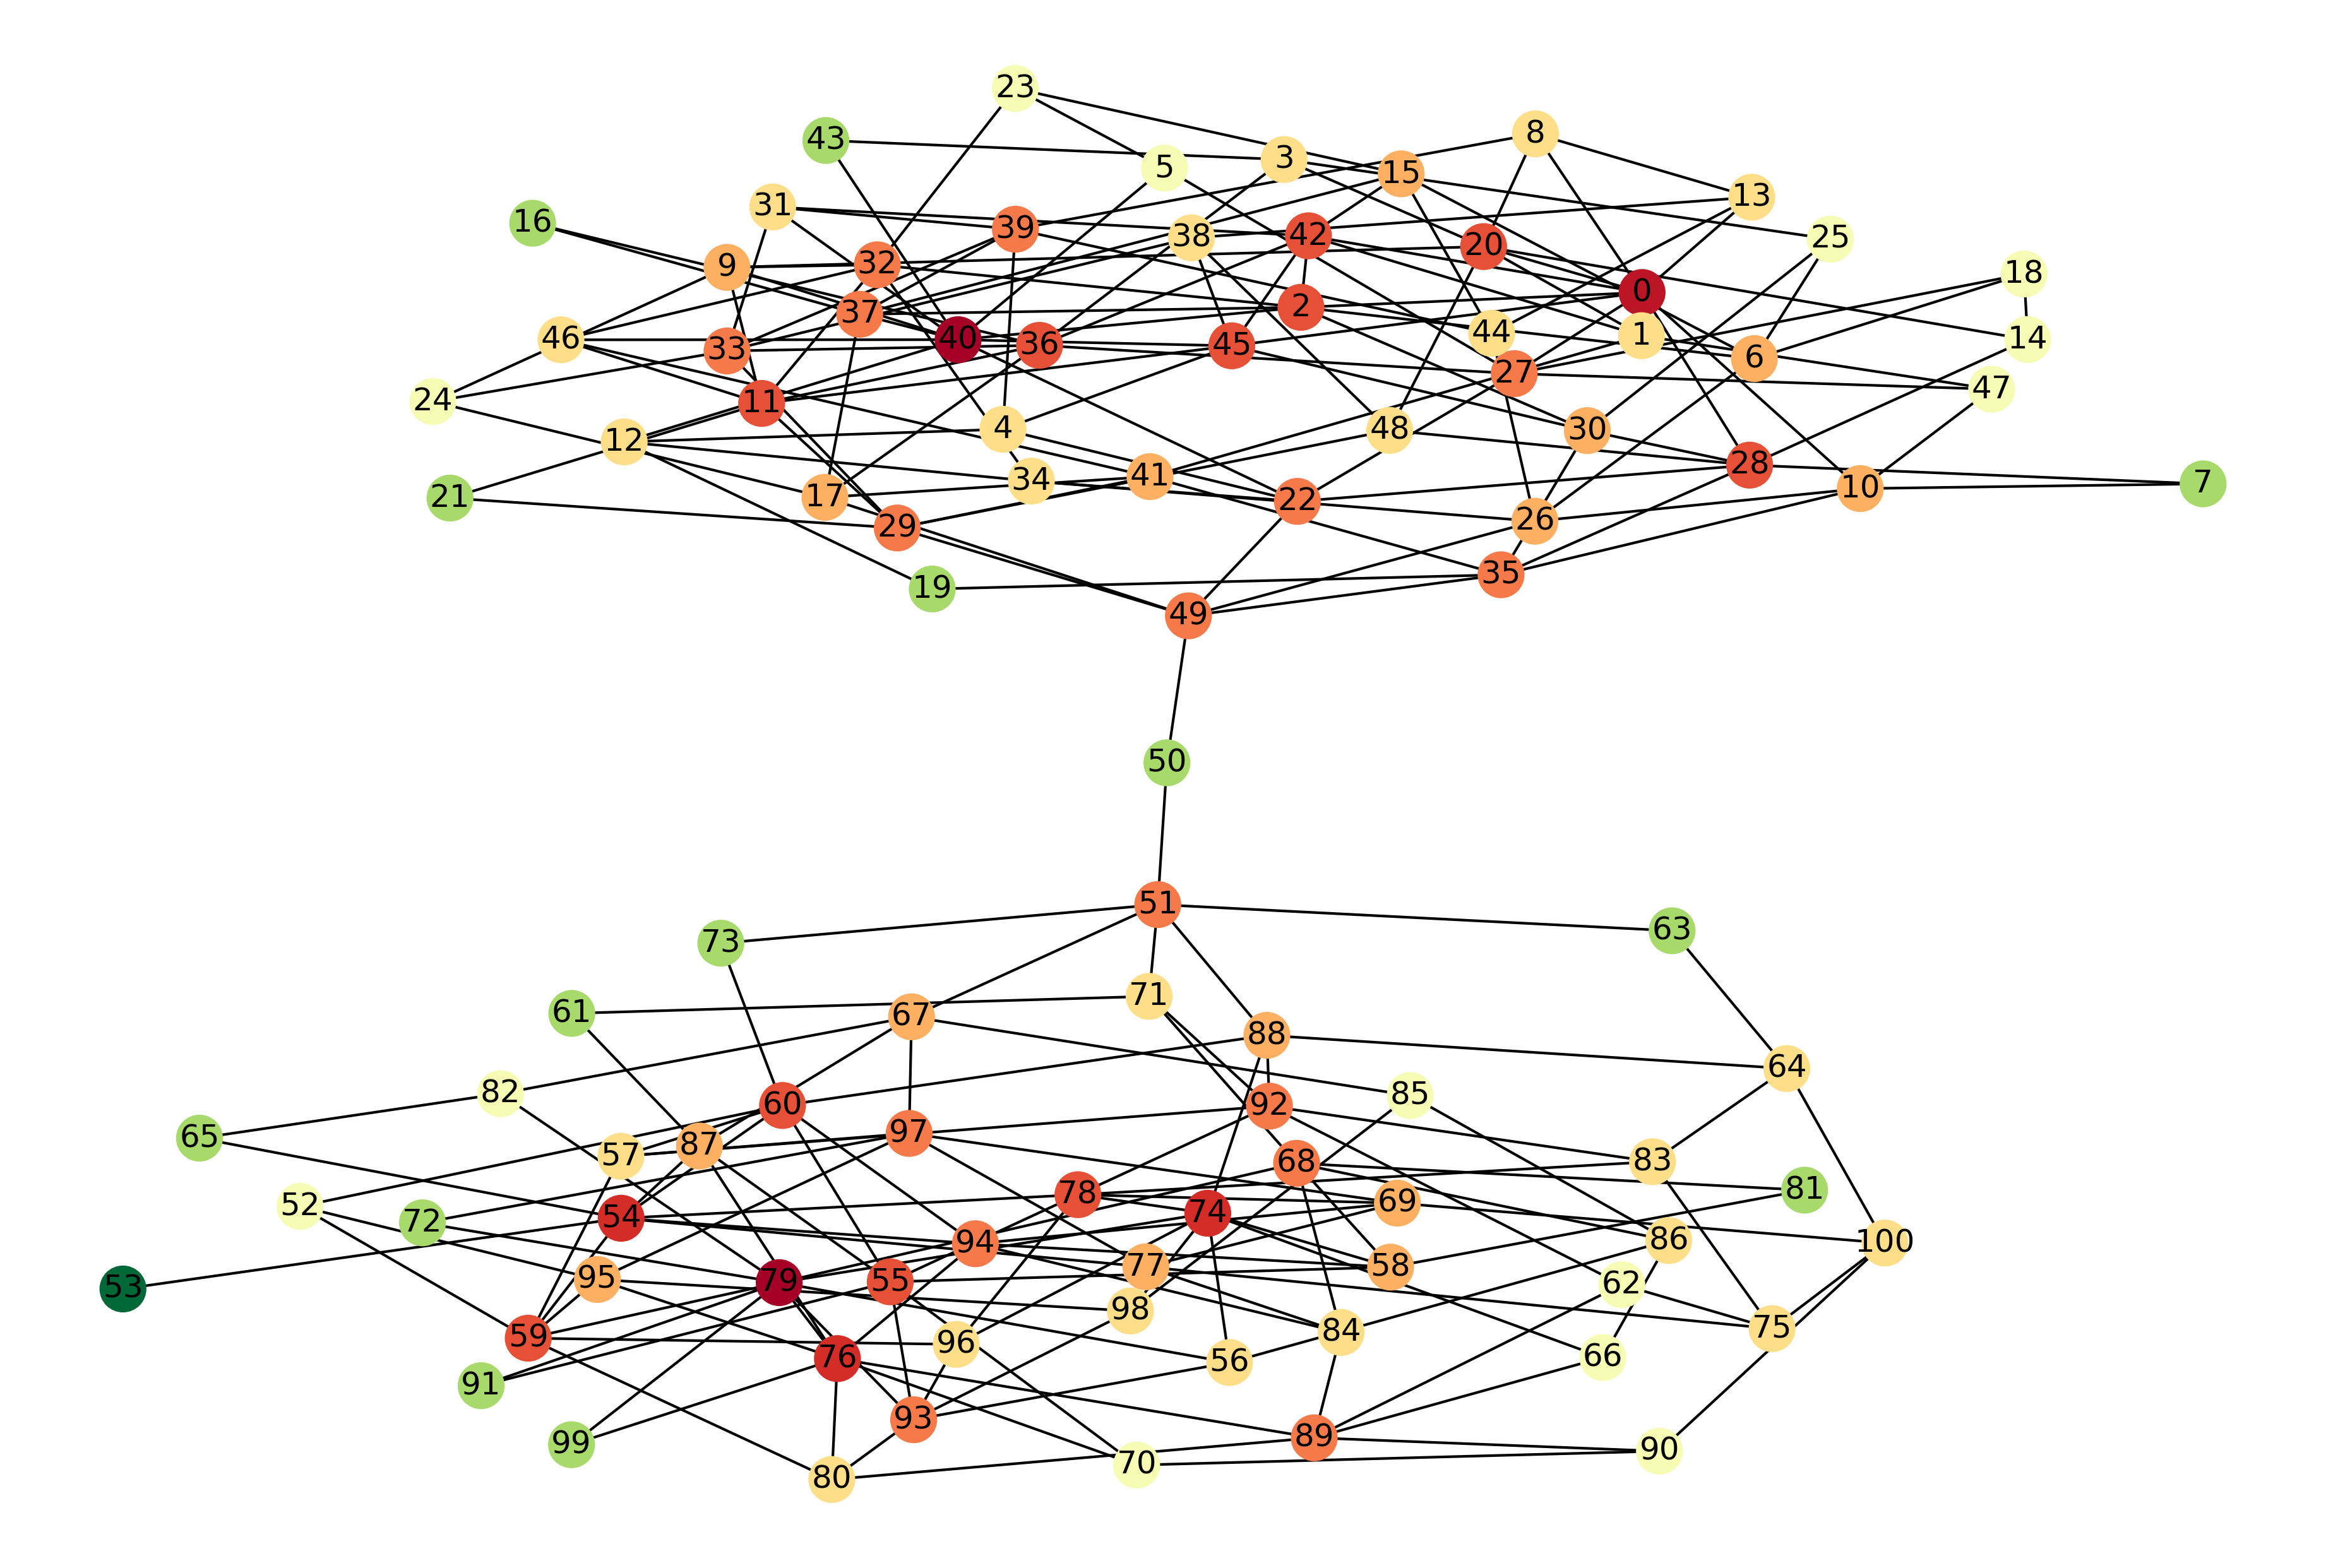

In [10]:
fig, ax = plt.subplots(1)

nx.draw_networkx(G, pos=pos, node_color=deg[2], ax=ax)
ax.axis('off');

# Closeness Centrality

Another of quantifying how important a node is is by how close it is to other nodes.We start by computing the shortest path between every pair of nodes

In [11]:
paths = nx.shortest_path(G)

Some paths can be pretty long. For example, the longest shortest path

In [12]:
max_length = 0
edge = []

for source in paths:
    for target in paths[source]:
        if len(paths[source][target]) > max_length:
            max_length = len(paths[source][target])
            edge = [source, target]

print(max_length)

11


Is 11 steps long. We extract this path

In [13]:
source, target = edge
edges = list(zip(paths[source][target][:-1], paths[source][target][1:]))

And plot it

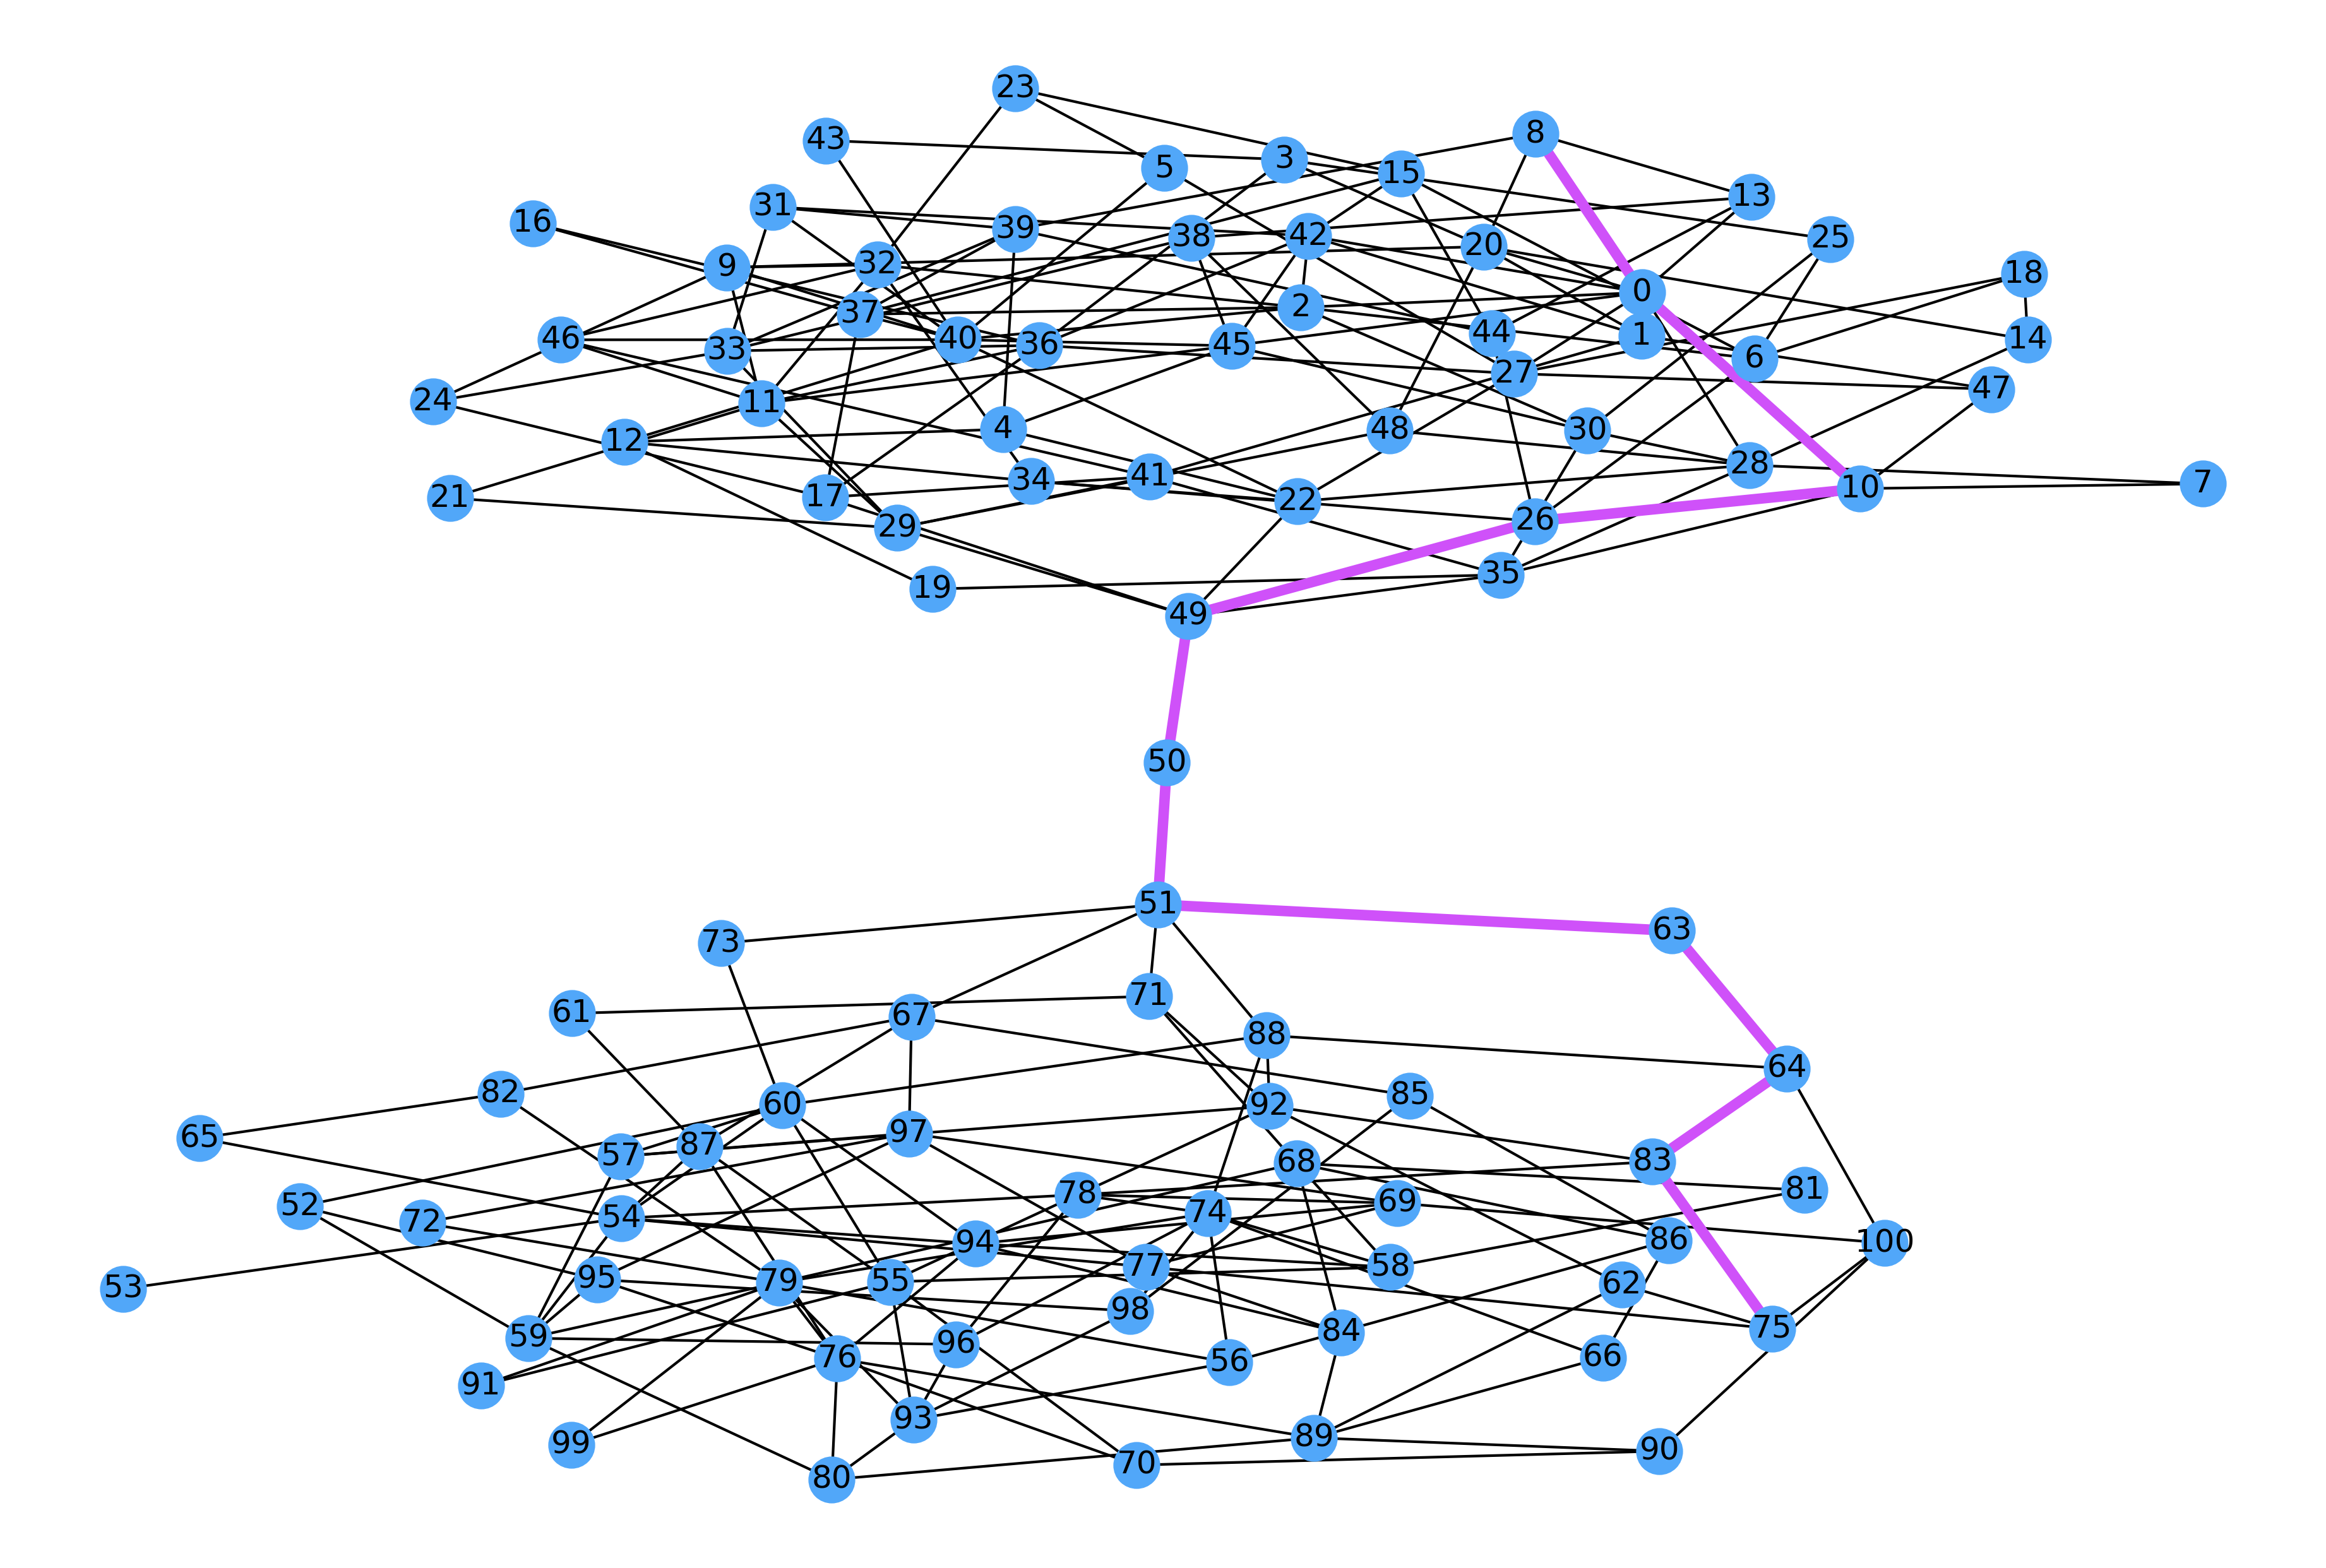

In [14]:
fig, ax = plt.subplots(1)

nx.draw_networkx(G, pos=pos, node_color=colors[0], ax=ax)
nx.draw_networkx_edges(G, pos, edges, edge_color=colors[1], width=4, ax=ax)
ax.axis('off');

So it should be clear that nodes like 8 and 75 should be less important than more central nodes like 50. Now we compute the inverse of the shortest path distance between each node and every other node. As we already have the shortest paths between every pair of nodes it's simple to compute the average distance as well

In [15]:
dist = {}

for source in paths:
    if source not in dist:
        dist[source] = 0
    
    for target in paths[source]:
        if source != target:
            # Add the distance between source and target
            # We subtract 1 so we don't count the source node
            dist[source] += (len(paths[source][target])-1) 

    # Calculate the inverse average distance
    dist[source] = (len(paths[source])-1)/dist[source] 

If we now color the nodes based on this measure of centrality, we obtain:

In [16]:
closeness = pd.DataFrame(dist.items()).set_index(0)
closeness[1] = np.log10(1+closeness[1]-closeness[1].min())/np.log10(closeness[1].max()+1-closeness[1].min())
closeness[2] = closeness[1].map(lambda x: cmap(x))

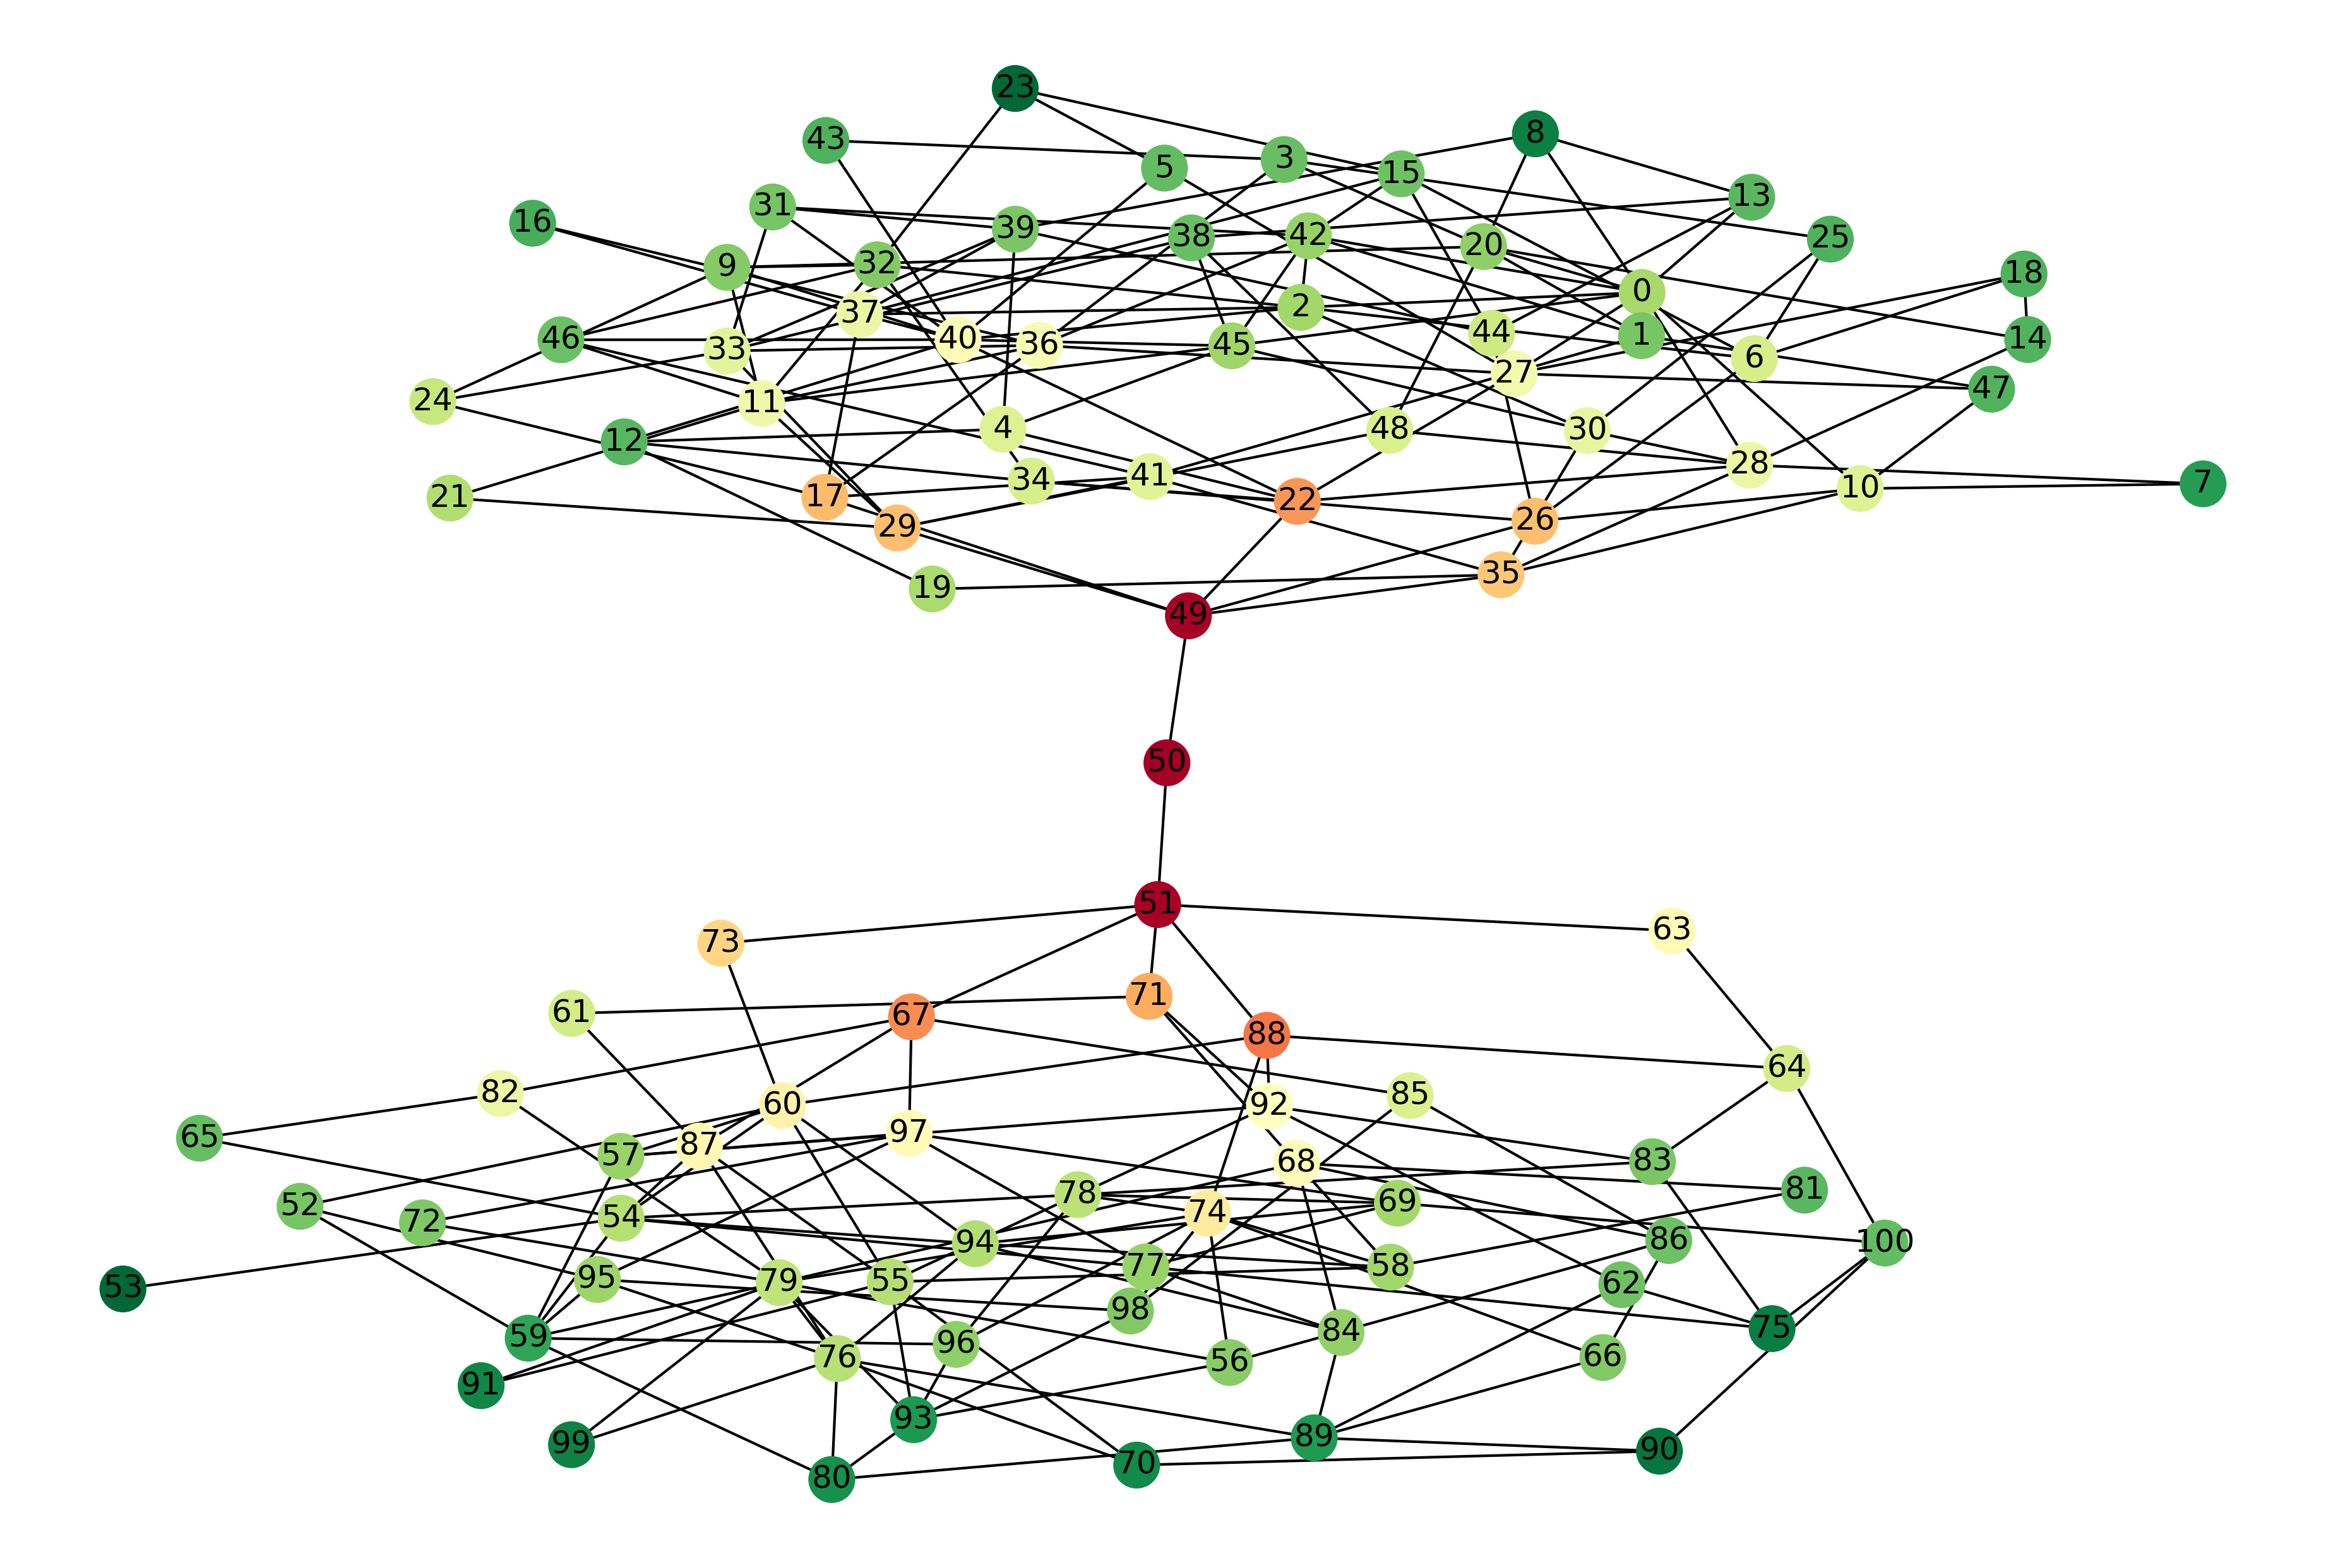

In [17]:
fig, ax = plt.subplots(1)

nx.draw_networkx(G, pos=pos, node_color=closeness[2], ax=ax)
ax.axis('off');

Unsurprisingly, we see that nodes that are closer to the center of the netowrk have a higher closer centrality than more peripheric nodes.

# Number of shortest paths

We can also compute the number of shortest paths that pass through each node

In [18]:
path_count = dict(zip(G.nodes(), np.zeros(G.number_of_nodes())))

for source in paths:
    for target in paths[source]:
        for node in paths[source][target][1:-1]:
            if node not in path_count:
                path_count[node] = 0
                
            path_count[node] += 1

Color the nodes based on the number of paths they contain

In [19]:
counts = pd.DataFrame(path_count.items()).set_index(0)
counts[1] = np.log10(1+counts[1]-counts[1].min())/np.log10(counts[1].max()+1-counts[1].min())
counts[2] = counts[1].map(lambda x: cmap(x))

And plot them

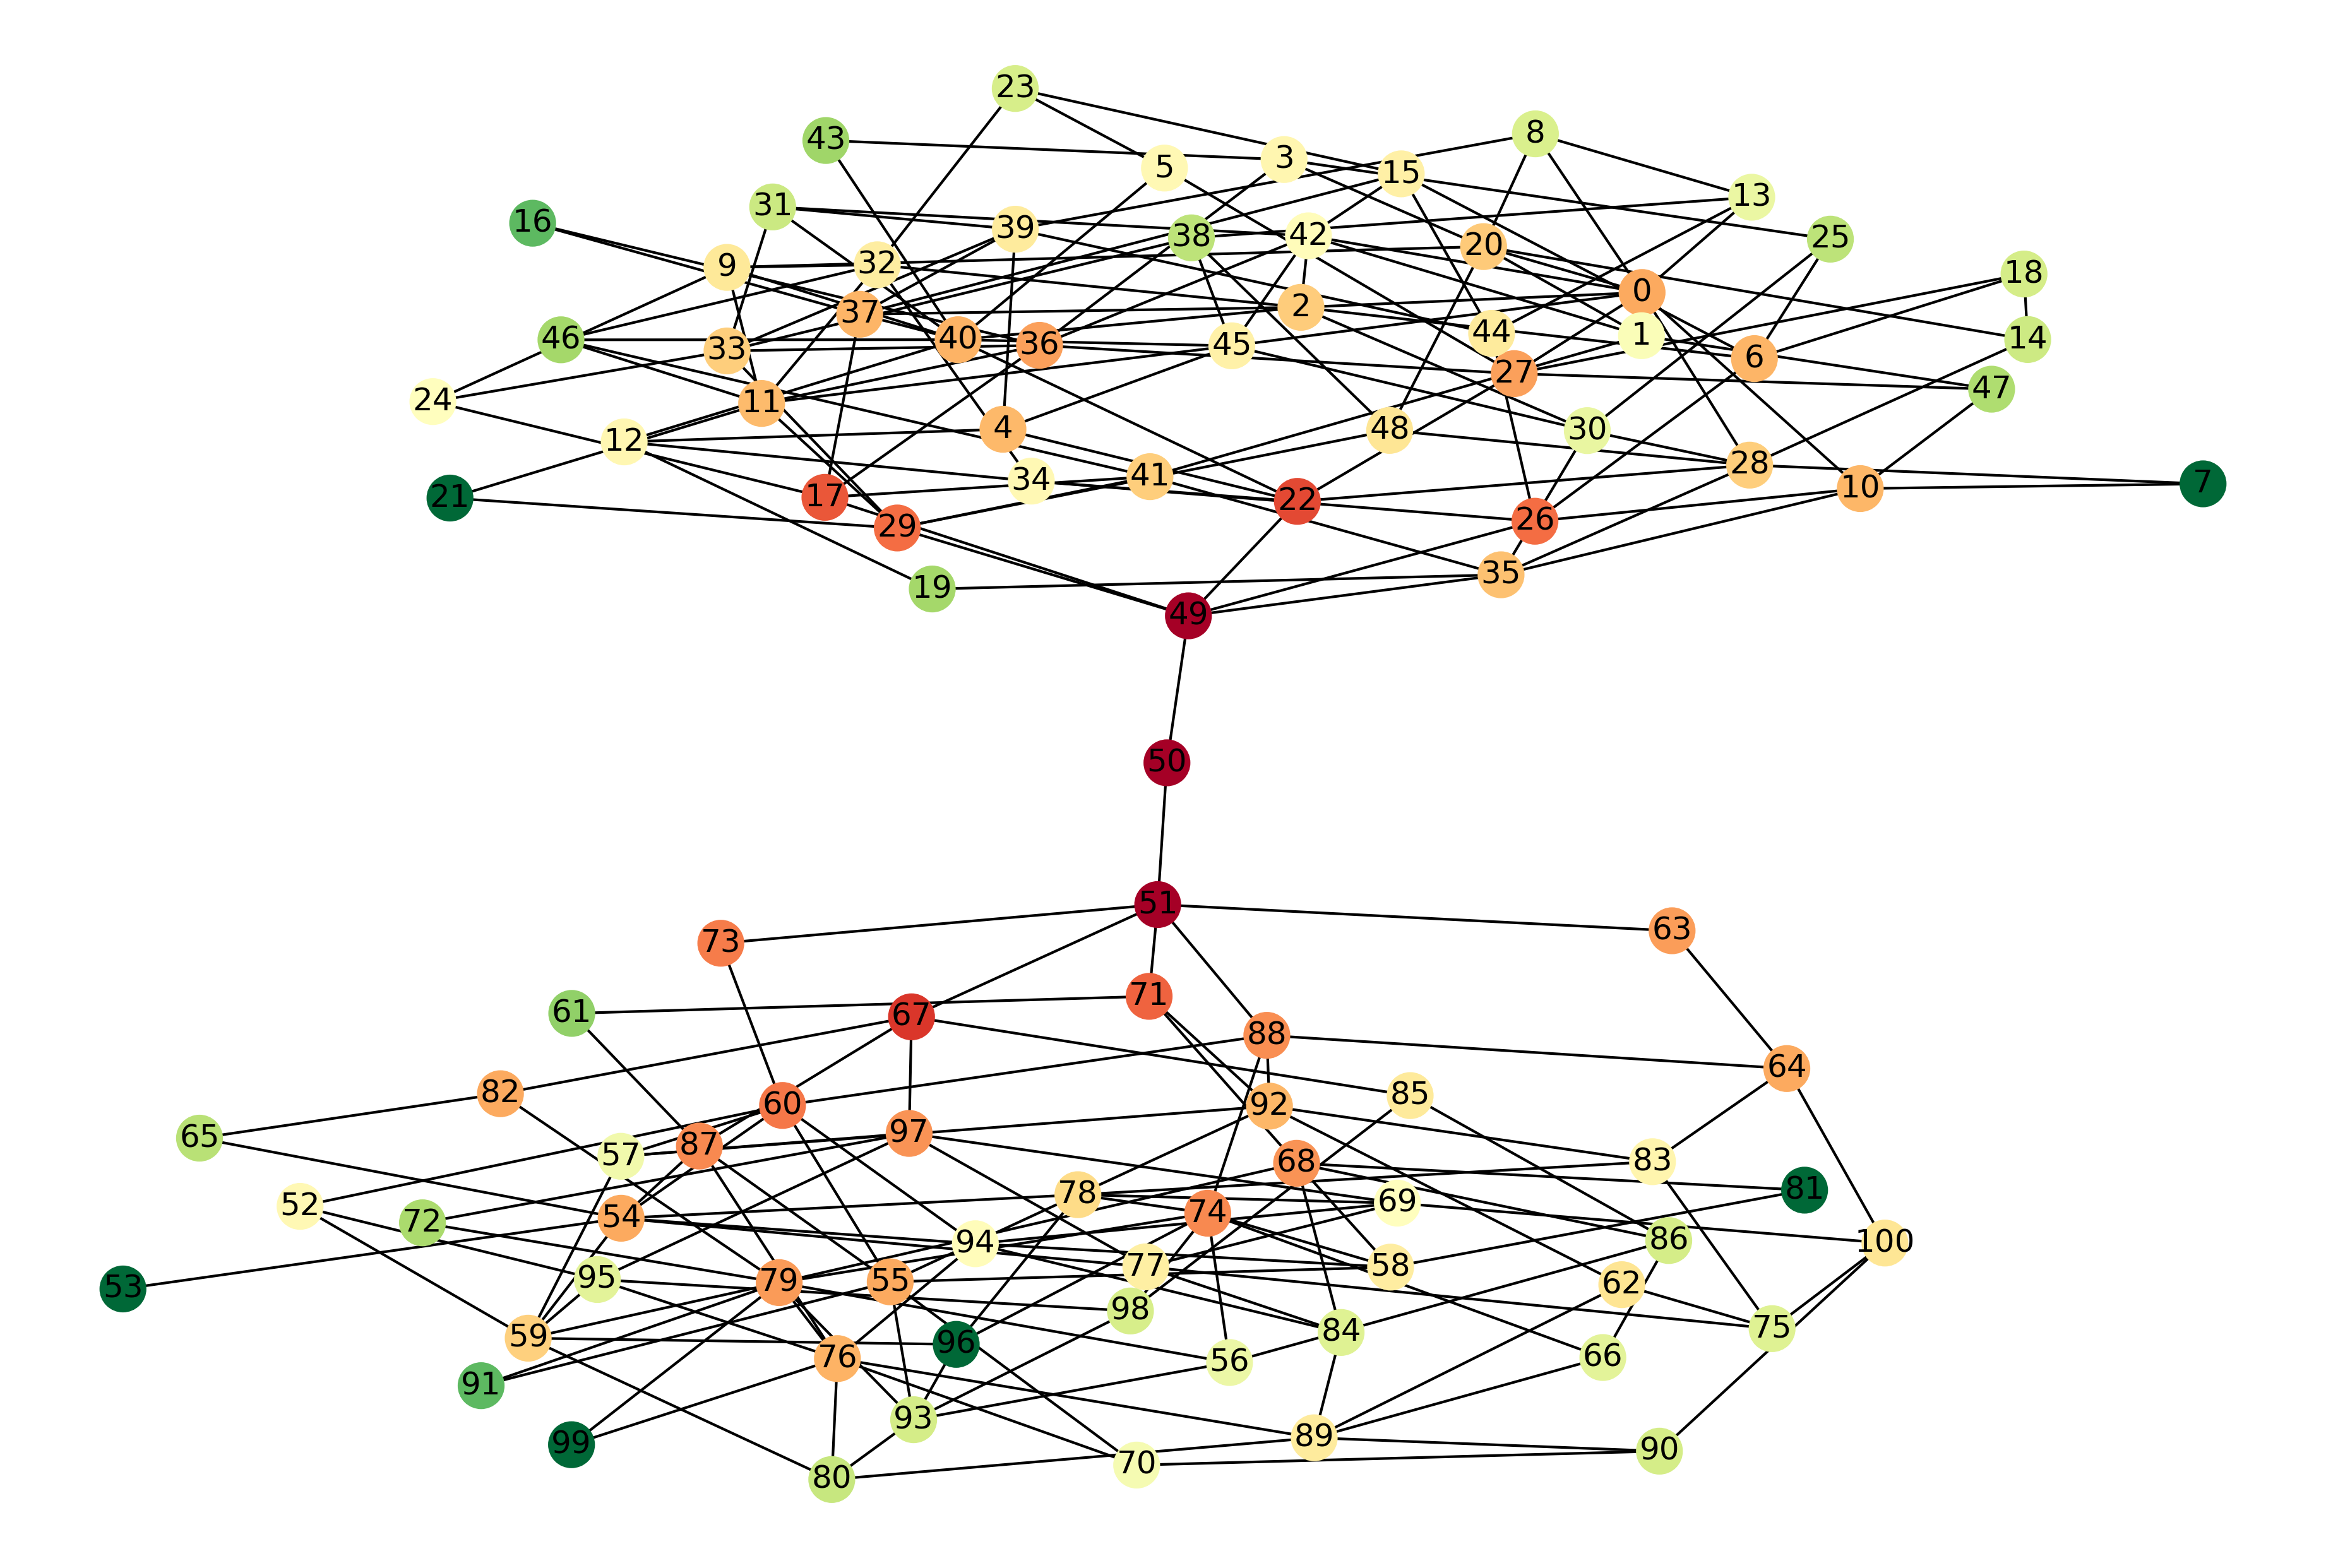

In [20]:
fig, ax = plt.subplots(1)

nx.draw_networkx(G, pos=pos, node_color=counts[2], ax=ax)
ax.axis('off');

Here the results are... muddled. The reason for this is that since we are using Dijkstra's algorithm we are returning just a single path for each pair of nodes, even though there might be several paths with the same length.

# Betweeness Centrality

Between centrality starts with our "shortest paths" approach and takes it one step further. It accounts for every shortest path between each pair of nodes and assigns each intermediate node a weight proportional to the fraction of shortest paths that cross it. For convenience, we use the networkx implementation

In [21]:
bet = nx.betweenness_centrality(G)
bet = pd.DataFrame(bet.items()).set_index(0)

bet[1] = np.log10(1+bet[1]-bet[1].min())/np.log10(bet[1].max()+1-counts[1].min())
bet[2] = bet[1].map(lambda x: cmap(x))

And plot it as before

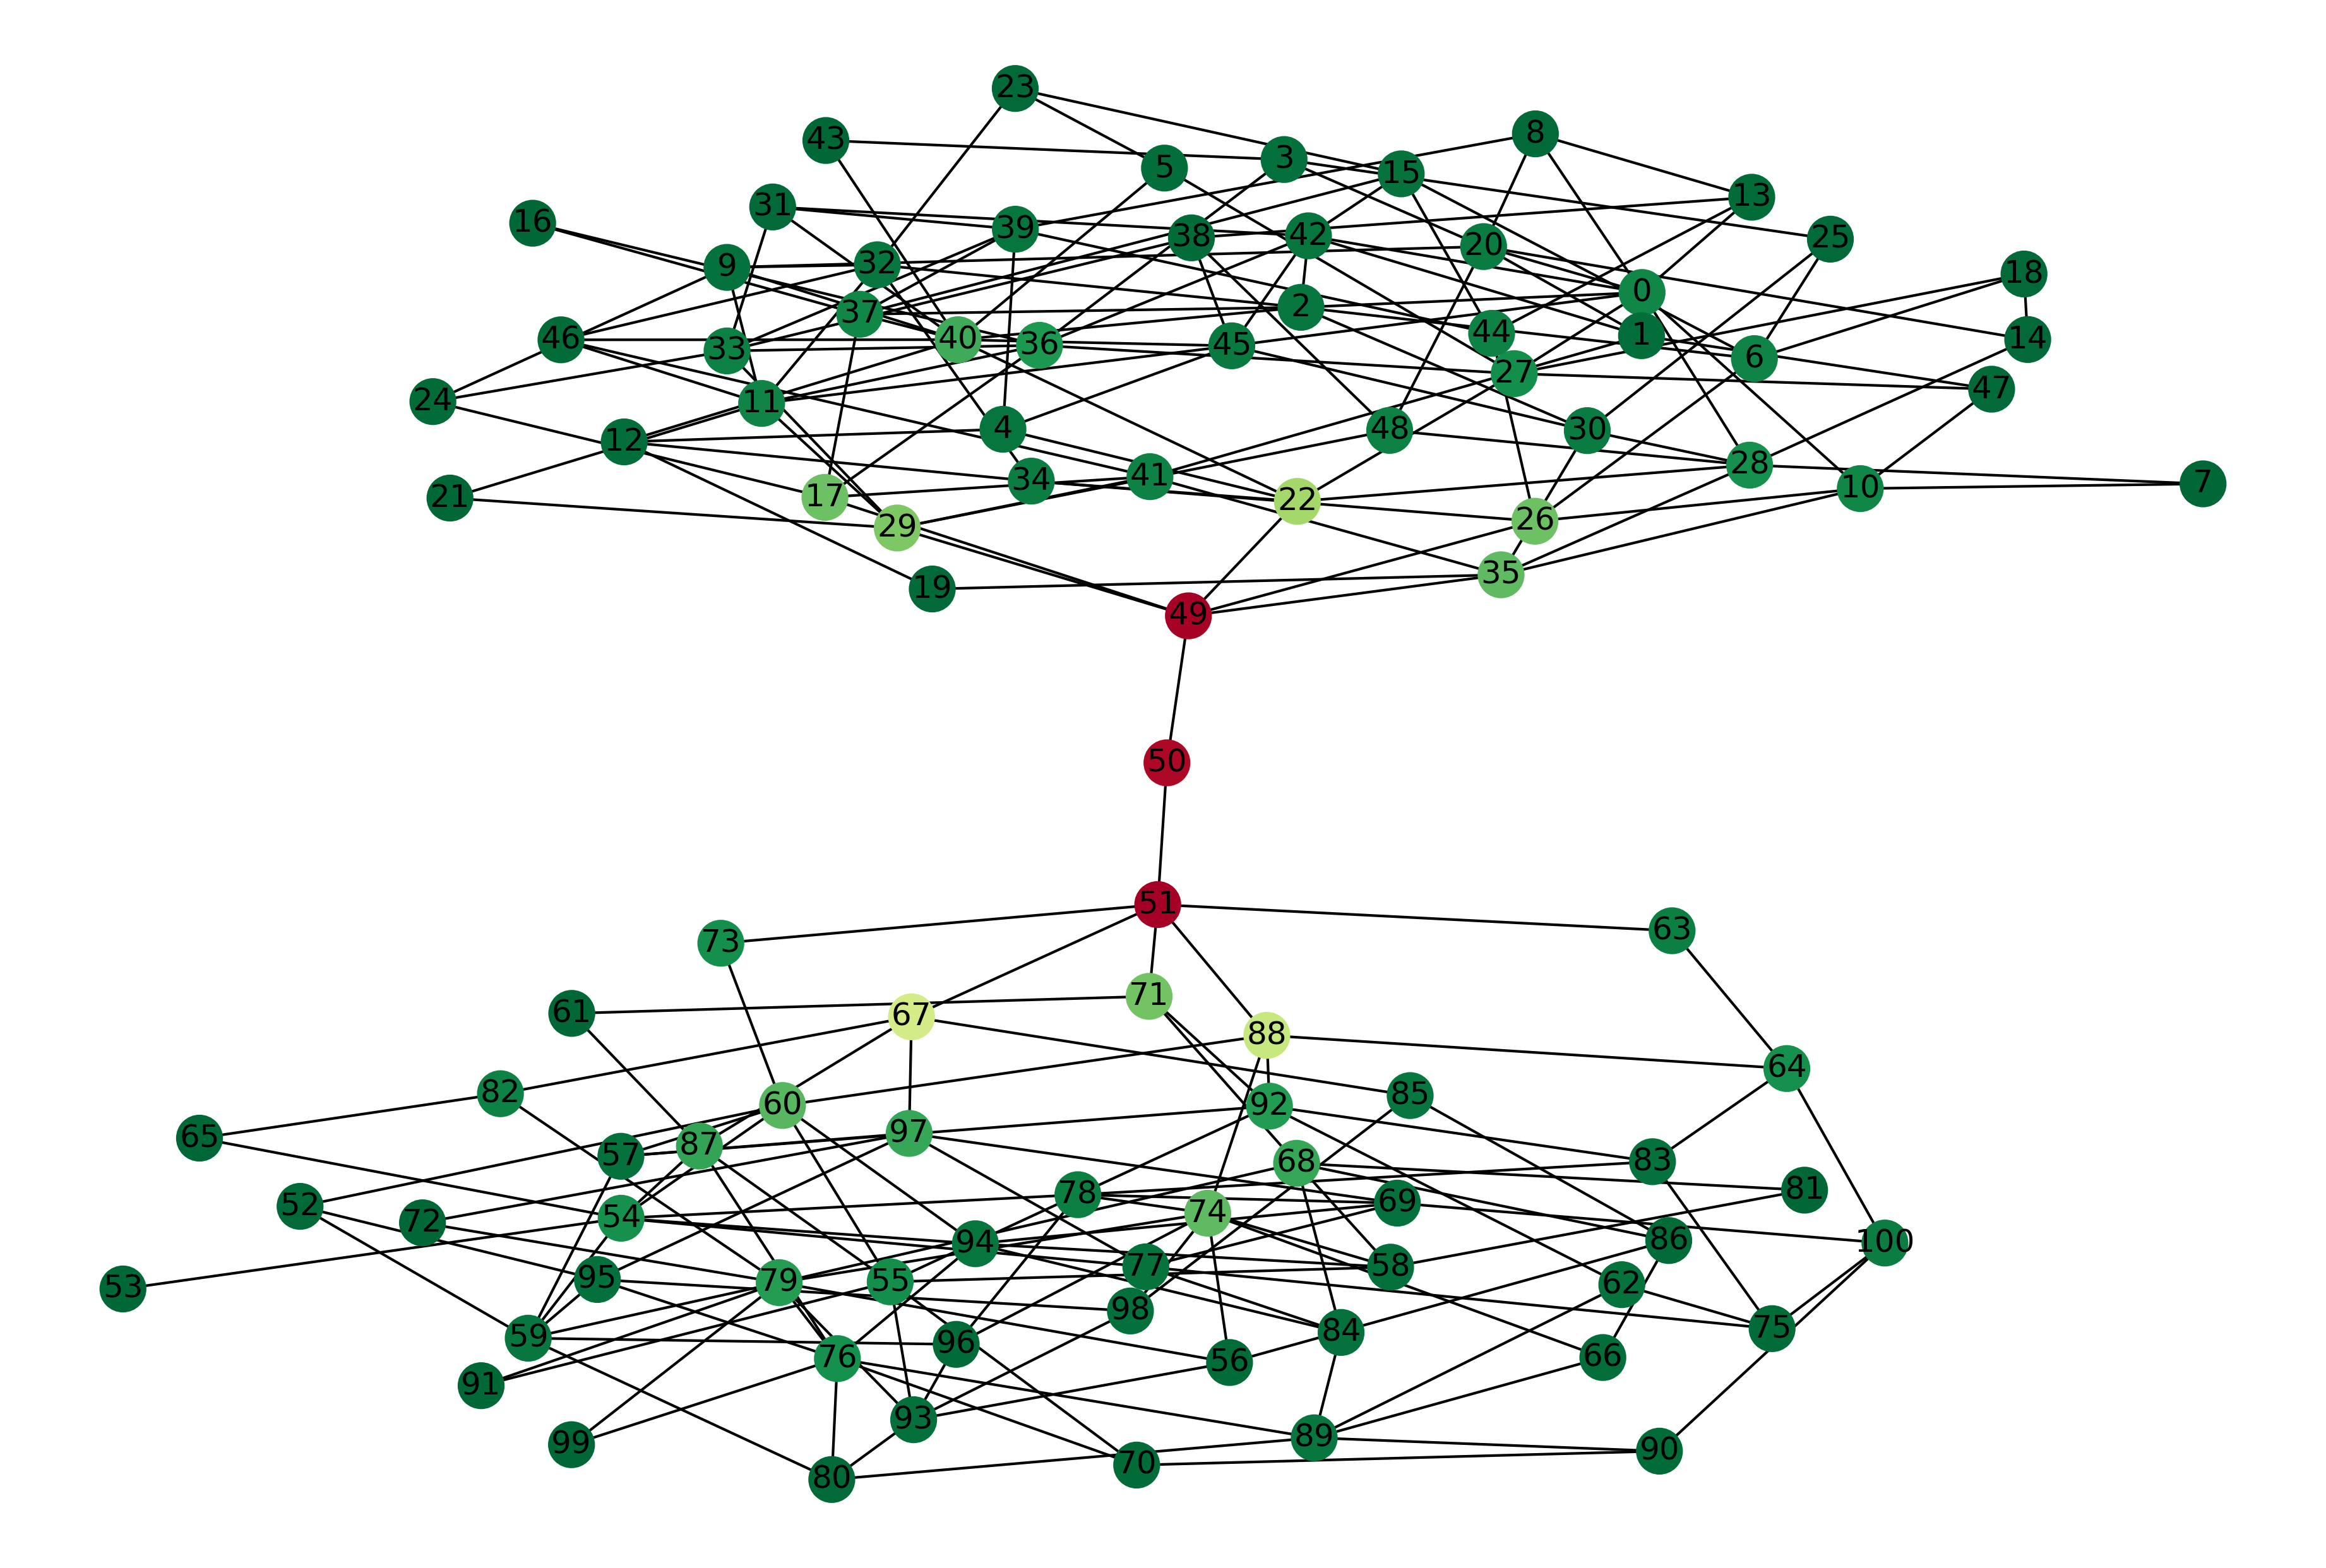

In [22]:
fig, ax = plt.subplots(1)

nx.draw_networkx(G, pos=pos, node_color=bet[2], ax=ax)
ax.axis('off');

Now we can see that the picture is much clearer. Nodes away from the center have low (and relatively similar) betweeness values that become increasingly larger as we get closer to the center of the network. A simple scatter plot drives the point home: While these two approaches are correlated, the betweeness centrality does a better job of equalizing similar nodes and can better be used as an indicator that a given node occupies a more central position in the network

Text(0, 0.5, 'Betweeness')

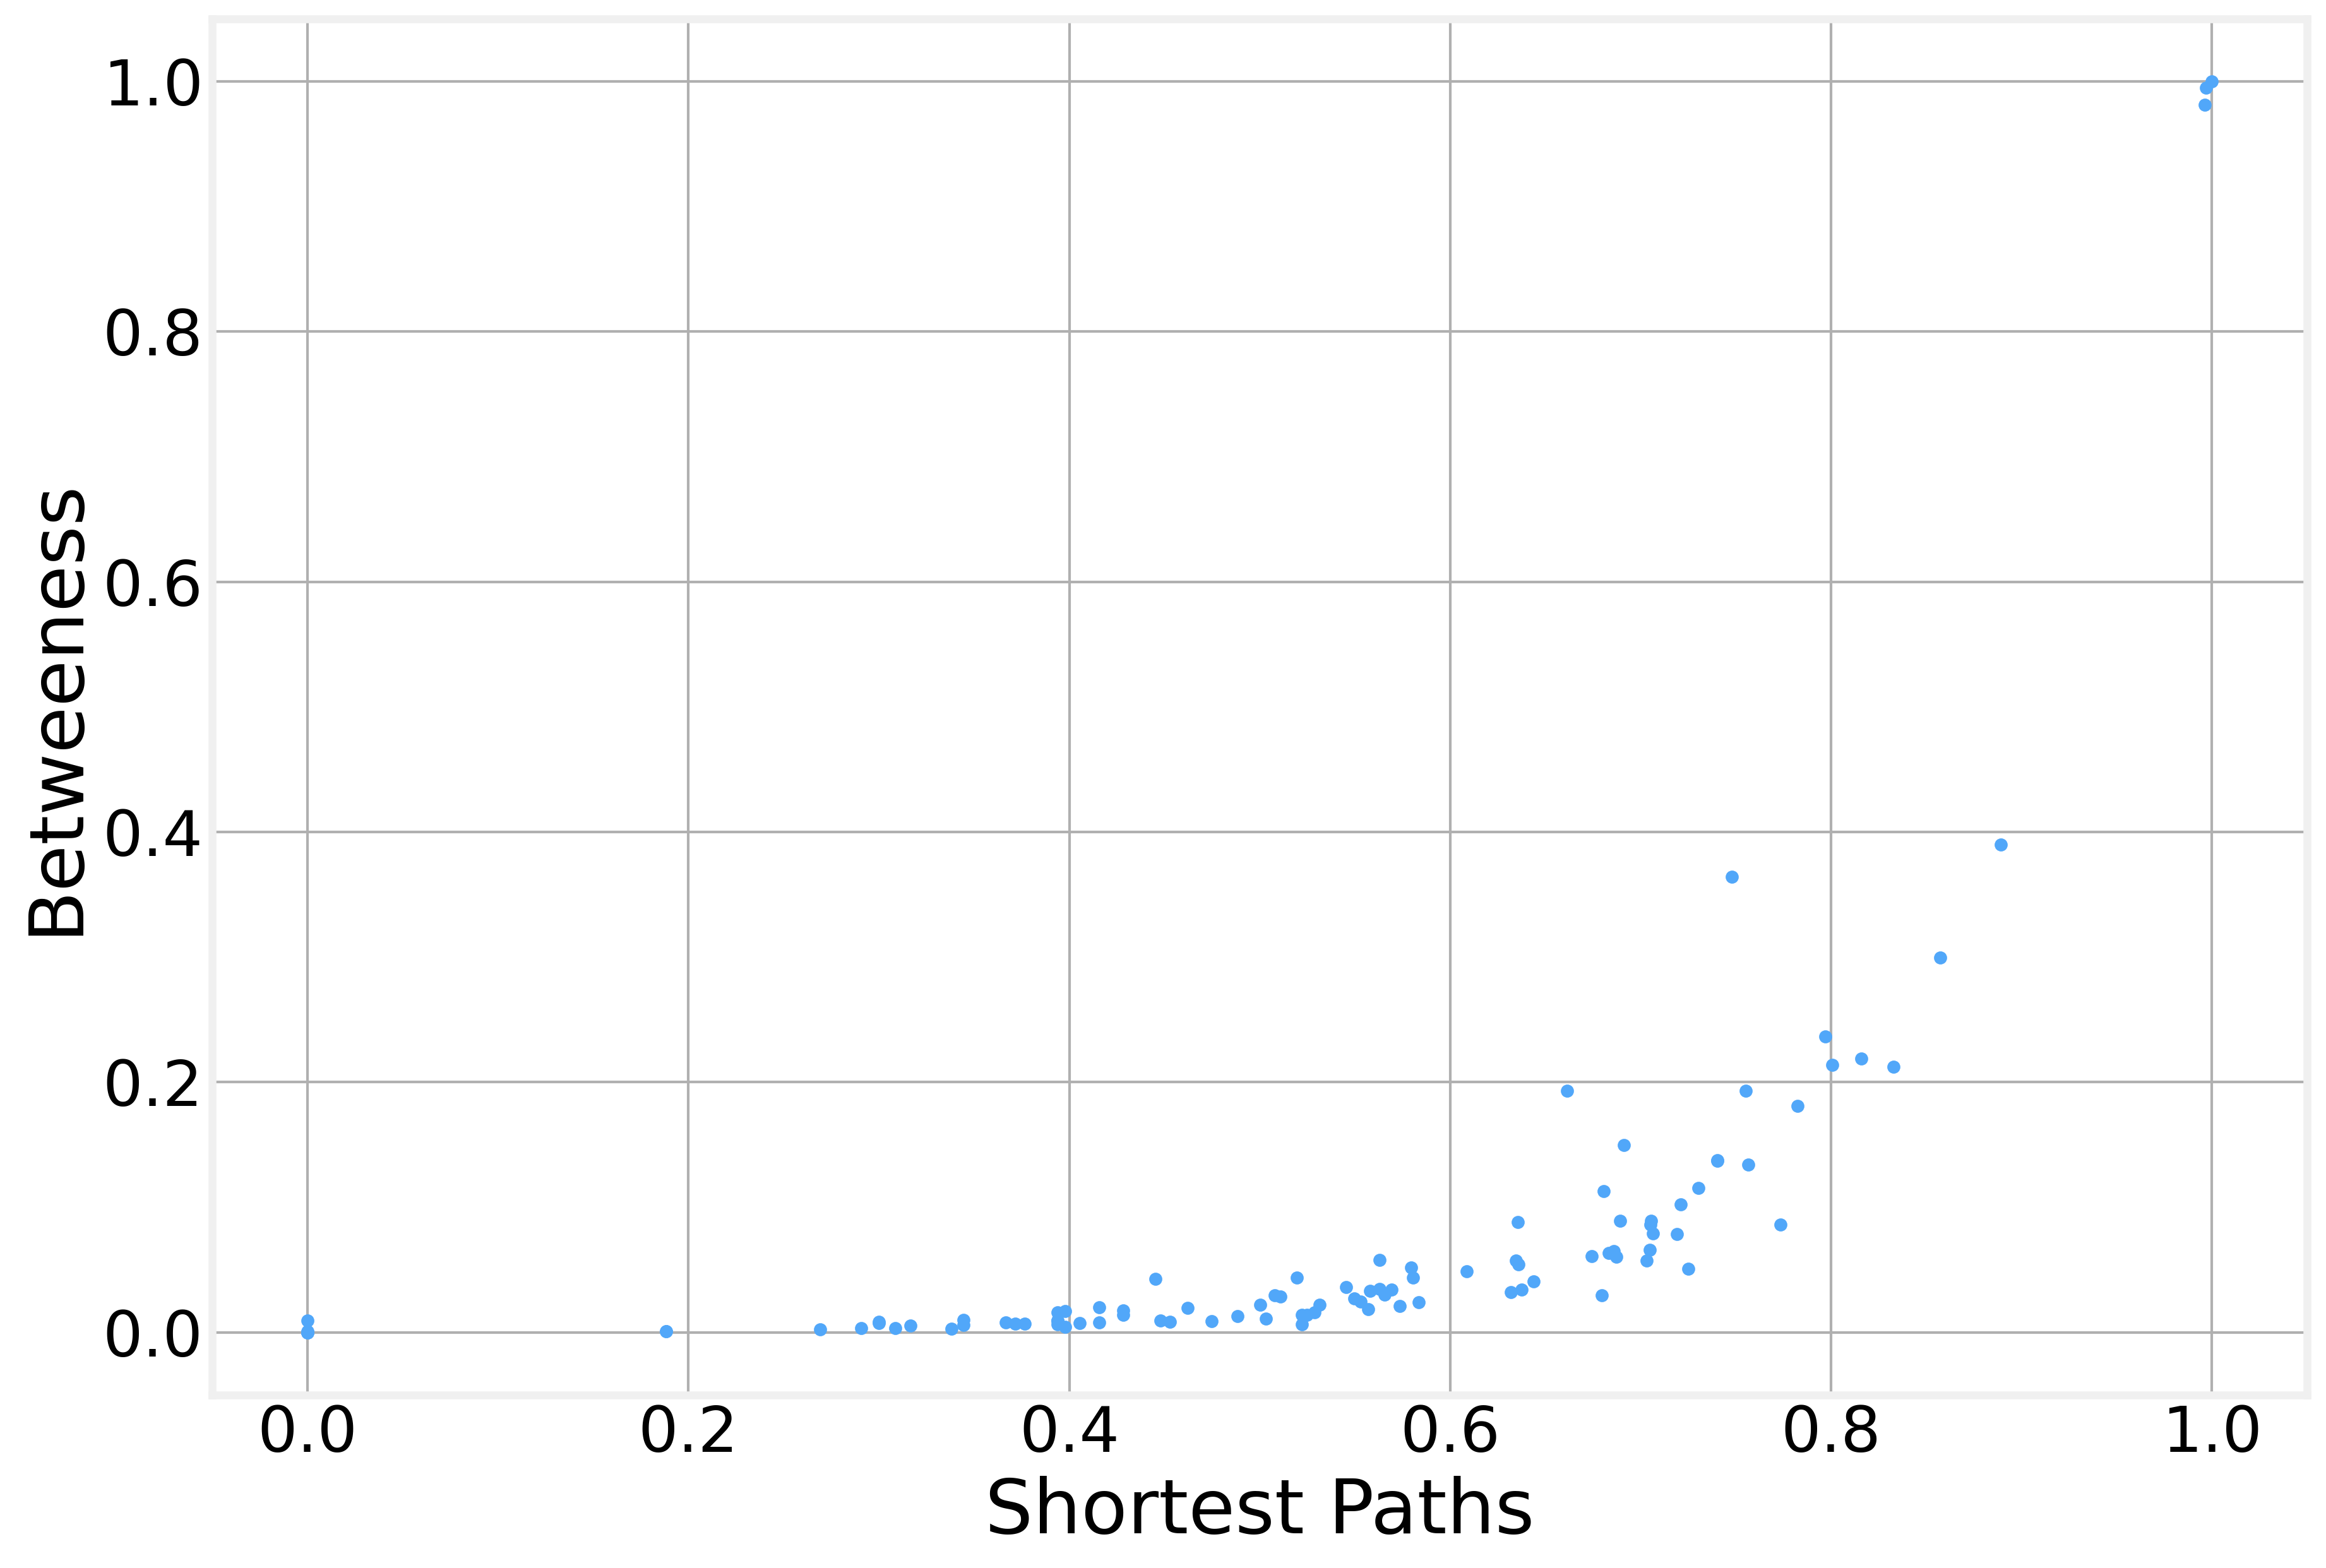

In [23]:
ax = counts[[1]].join(bet[[1]], lsuffix='_d', rsuffix='_b').plot.scatter(x='1_d', y='1_b')
ax.set_xlabel('Shortest Paths')
ax.set_ylabel('Betweeness')

<div style="width: 100%; overflow: hidden;">
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>